> ### EEE4423: Deep Learning Lab

# LAB \#12: Sequence to Sequence Network with Attention Module
## Machine Translation with Attention

<h4><div style="text-align: right"> Due date: May 27, 2022. </div> <br>
<div style="text-align: right"> Please upload your file @ LearnUs by 9 AM in the form of [ID_Name_Lab12.ipynb]. </div></h4>

### *Instructions:*
- Write a program implementing a particular algorithm to solve a given problem.   
- <span style="color:red">**Report and discuss your results. Analyze the algorithm, theoretically and empirically.**</span> 
- Each team must write their own answers and codes (<span style="color:red">**if not you will get a F grade**</span>).

<h2><span style="color:blue">[2019142079] [성재진]</span> </h2>

In [1]:
import datetime
print("This code is written at " + str(datetime.datetime.now()))

This code is written at 2023-05-25 03:18:36.429045


In this project we will be teaching a neural network to translate from
French to English.
*************************************************************
::

    [(>): input, (=): target, (<): output]

    > il est en train de peindre un tableau .
    = he is painting a picture .
    < he is painting a picture .

    > pourquoi ne pas essayer ce vin delicieux ?
    = why not try that delicious wine ?
    < why not try that delicious wine ?

    > elle n est pas poete mais romanciere .
    = she is not a poet but a novelist .
    < she not not a poet but a novelist .

    > vous etes trop maigre .
    = you re too skinny .
    < you re all alone .

...
*************************************************************

In [2]:
from __future__ import unicode_literals, print_function, division
from io import open
import unicodedata
import string
import re
import random

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### 1. Prepare data

The data for this project is a set of many thousands of English to French translation pairs. Download the data from <https://download.pytorch.org/tutorial/data.zip>. The file is a tab separated list of translation pairs:


    I am cold.    J'ai froid.
    
<img src="https://drive.google.com/uc?export=view&id=1K3W2RxeTKih5IiT5PcIyWNZSwMqtYSGZ"  onerror="this.style.display='none'" style="width: 600px;"/><br><br>

In [3]:
SOS_token = 0
EOS_token = 1
MAX_LENGTH = 10
eng_prefixes = (
    "i am ", "i m ",
    "he is", "he s ",
    "she is", "she s ",
    "you are", "you re ",
    "we are", "we re ",
    "they are", "they re ")

class Lang:
    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: "SOS", 1: "EOS"}
        self.n_words = 2  # Count SOS and EOS

    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1
            
def filterPair(p):
    return len(p[0].split(' ')) < MAX_LENGTH and \
        len(p[1].split(' ')) < MAX_LENGTH and \
        p[1].startswith(eng_prefixes)

def filterPairs(pairs):
    return [pair for pair in pairs if filterPair(pair)]

# Turn a Unicode string to plain ASCII, thanks to https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join( c for c in unicodedata.normalize('NFD', s) if unicodedata.category(c) != 'Mn')

# Lowercase, trim, and remove non-letter characters
def normalizeString(s):
    s = unicodeToAscii(s.lower().strip())
    s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"[^a-zA-Z.!?]+", r" ", s)
    return s

def readLangs(lang1, lang2, reverse=False):
    # Read the file and split into lines
    lines = open('./dataset-dllab/lab12/%s-%s.txt' % (lang1, lang2), encoding='utf-8').\
        read().strip().split('\n')

    # Split every line into pairs and normalize
    pairs = [[normalizeString(s) for s in l.split('\t')] for l in lines]

    # Reverse pairs, make Lang instances
    if reverse:
        pairs = [list(reversed(p)) for p in pairs]
        input_lang = Lang(lang2)
        output_lang = Lang(lang1)
    else:
        input_lang = Lang(lang1)
        output_lang = Lang(lang2)

    return input_lang, output_lang, pairs

def prepareData(lang1, lang2, reverse=False):
    input_lang, output_lang, pairs = readLangs(lang1, lang2, reverse)
    print("Read %s sentence pairs" % len(pairs))

    pairs = filterPairs(pairs)
    print("Trimmed to %s sentence pairs" % len(pairs))

    for pair in pairs:
        input_lang.addSentence(pair[0])
        output_lang.addSentence(pair[1])
    print("Counted words:", input_lang.name, '=', input_lang.n_words, output_lang.name, '=', output_lang.n_words)
    return input_lang, output_lang, pairs

input_lang, output_lang, pairs = prepareData('eng', 'fra', True)
print(random.choice(pairs))

Read 135842 sentence pairs
Trimmed to 10599 sentence pairs
Counted words: fra = 4345 eng = 2803
['tu es trop tendue .', 'you re too tense .']


In [4]:
def indexesFromSentence(lang, sentence):
    return [lang.word2index[word] for word in sentence.split(' ')]

def tensorFromSentence(lang, sentence):
    indexes = indexesFromSentence(lang, sentence)
    indexes.append(EOS_token)
    return torch.tensor(indexes, dtype=torch.long, device=device).view(-1, 1)

def tensorsFromPair(pair):
    input_tensor = tensorFromSentence(input_lang, pair[0])
    target_tensor = tensorFromSentence(output_lang, pair[1])
    return (input_tensor, target_tensor)

### 2. Build the Seq2Seq model [5 points]

<img src="https://drive.google.com/uc?export=view&id=1kKXrIIxi0t-Nm5HfzOukqjzEp7yEXEpV"  onerror="this.style.display='none'" /><br><br>

[sequence to sequence network](https://arxiv.org/abs/1409.3215) is a model in which two
recurrent neural networks work together to transform one sequence to
another. An encoder network condenses an input sequence into a single vector,
and a decoder network unfolds that vector into a new sequence.

Unlike sequence prediction with a single RNN, where every input
corresponds to an output, the seq2seq model frees us from sequence
length and order, which makes it ideal for translation between two
languages.

#### Encoder
The encoder of a seq2seq network is a RNN that outputs some value for every word from the input sentence. For every input word the encoder outputs a vector and a hidden state, and uses the hidden state for the next input word.  
<img src="https://drive.google.com/uc?export=view&id=1PyKBEVl5jwQfB0I0P2kG8nTGQVZQdZEM"  onerror="this.style.display='none'" /><br><br>

#### GRU
<img src="https://drive.google.com/uc?export=view&id=1467jVFRYbw1DYvVKeSyzGWLRmtlqpy8z"  onerror="this.style.display='none'" style="width: 700px;"/><br><br>
The GRU operates using a reset gate (r) and an update gate (z). The candidate state is created by using the previous hidden state and the current input. It is the reset gate that determines how the previous hidden state affects the candidate state. The newly created candidate state and the previous hidden state create a new hidden state, in which the update gate plays a role in balancing the two.

#### LSTM vs GRU
<img src="https://drive.google.com/uc?export=view&id=1lzGTsIYvPWKNF-XaTevMaaZvjfgp9G35"  onerror="this.style.display='none'" style="width: 600px;"/><br><br>

| <center>LSTM</center> | <center>GRU</center>  |
|:--------|--------|
| LSTM has 3 gates (forget, input, output) | GRU has 2 gates (reset, update) |
| There is an internal memory (cell state) | There is no cell state and only hidden state exists |
| When making output, another non-linearity is applied | There is no additional non-linearity when making output  |

In [5]:
# 2 points
class EncoderRNN(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(EncoderRNN, self).__init__()
        
        self.hidden_dim = hidden_dim

        self.embedding = nn.Embedding(input_dim, hidden_dim)
        # gru
        # The size of input is (batch_size, seq_dim, hidden_dim)
        #############
        #주어진 공식을 만들기 위해 matrix를 linear로 정의해준다.
        self.U_z = nn.Linear(self.hidden_dim, self.hidden_dim)
        self.W_z = nn.Linear(self.hidden_dim, self.hidden_dim)
        self.U_r = nn.Linear(self.hidden_dim, self.hidden_dim)
        self.W_r = nn.Linear(self.hidden_dim, self.hidden_dim)
        self.U_h = nn.Linear(self.hidden_dim, self.hidden_dim)
        self.W_h = nn.Linear(self.hidden_dim, self.hidden_dim)
        self.sigmoid=nn.Sigmoid()
        self.tanh=nn.Tanh()
        #############

    def forward(self, input, hn):
        #############
        #input을 embedding하고 GRU의 gate를 위에 주어진 공식대로 적어준다.
        embedded = self.embedding(input).view(1,1,-1)
        z_t=self.sigmoid(self.U_z(embedded)+self.W_z(hn))
        r_t=self.sigmoid(self.U_r(embedded)+self.W_r(hn))
        h_tilde_t=self.tanh(self.U_h(embedded)+self.W_h(hn*r_t))
        hn=(1-z_t)*h_tilde_t+z_t*hn
        output=hn
        #############
        return output, hn

    def initHidden(self):
        # The size of h0 should be (layer_dim, batch_size, hidden_dim)
        #############
        h0 = torch.zeros(1,1, self.hidden_dim).cuda()#hidden state initializ
        #############
        return h0
    
hidden_dim = 256
encoder = EncoderRNN(input_lang.n_words, hidden_dim).to(device)

#### Decoder
<img src="https://drive.google.com/uc?export=view&id=1Rm_LlpEolCvPuzPWEFOZ-zdTfsgMbtu-"  onerror="this.style.display='none'" /><br><br>

If only the context vector is passed betweeen the encoder and decoder, that single vector carries the burden of encoding the entire sentence. Attention allows the decoder network to "focus" on a specific part of
the encoder's outputs for every step and thus help the decoder choose the right output words. 

<img src="https://drive.google.com/uc?export=view&id=18hsS8PAA7I3QaN9oOebfnMGAMhR-6EID"  onerror="this.style.display='none'" style="width: 170px;"/><br><br>

<img src="https://drive.google.com/uc?export=view&id=1F1Y92uLvGaI6s-ygyNKNox4ZGiZmTZ3g"  onerror="this.style.display='none'" style="width: 170px;"/><br><br>

The attention weights are calculated using an another feed-forward layer which inputs the decoder's input and hidden state. And the calculated attention weight is multiplied to the corresponding hidden state of the encoder, respectively. Note that to actually create and train this layer we have to choose a maximum sentence length. Sentences of the maximum length will use all the attention weights, while shorter sentences will only use the first few.

<img src="https://drive.google.com/uc?export=view&id=1JEE23gtJf4XciJUXLt2R9lZtpRn8mYCN"  onerror="this.style.display='none'" /><br><br>

In [6]:
# 3 points
class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_dim, output_dim, dropout_p=0.1):
        super(AttnDecoderRNN, self).__init__()
        
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim
        self.dropout_p = dropout_p

        self.embedding = nn.Embedding(self.output_dim, self.hidden_dim)
        self.dropout = nn.Dropout(self.dropout_p)
        
        # attention
        # Note that the column of the attention weights is MAX_LENGTH
        # Note that concatenation is used when "attn" and "attn_combine" are created
        #############
        #위의 그림처럼 attn과 attn_combine을 만들어준다.
        self.attn = nn.Linear(self.hidden_dim * 2, MAX_LENGTH)#prev_hidden과 embedded가 concatenate
        self.attn_combine = nn.Linear(self.hidden_dim * 2, self.hidden_dim)#attn_applied와 embedded가 concatenate
        #############
        
        # gru
        # The size of input is (batch_size, seq_dim, hidden_dim)
        #############
        #encoder와 같다.
        self.U_z = nn.Linear(self.hidden_dim, self.hidden_dim)
        self.W_z = nn.Linear(self.hidden_dim, self.hidden_dim)
        self.U_r = nn.Linear(self.hidden_dim, self.hidden_dim)
        self.W_r = nn.Linear(self.hidden_dim, self.hidden_dim)
        self.U_h = nn.Linear(self.hidden_dim, self.hidden_dim)
        self.W_h = nn.Linear(self.hidden_dim, self.hidden_dim)
        self.sigmoid=nn.Sigmoid()
        self.tanh=nn.Tanh()
        #############
        
        self.out = nn.Linear(self.hidden_dim, self.output_dim)

    def forward(self, input, hn, encoder_outputs):
        input= self.embedding(input).view(1, 1, -1)#input_embedding
        input = self.dropout(input)#impu_dropout
        
        # attention
        # All specifications of the operations are described in the above figure (e.g. use ReLU)
        # bmm is a operation which performs a batch matrix-matrix product
        #############
        #주어진 그래프대로 수행한다.
        attn=self.attn(torch.cat((input, hn), 2))
        attn_weights = F.softmax(attn, dim=2)
        attn_applied = torch.bmm(attn_weights, encoder_outputs.unsqueeze(0))
        attn_combine = torch.cat((input, attn_applied), 2)
        attn_combine = self.attn_combine(attn_combine)
        attn_combine = F.relu(attn_combine)
        #############
        
        # gru
        #############
        #encoder와 같다.
        z_t=self.sigmoid(self.U_z(attn_combine)+self.W_z(hn))
        r_t=self.sigmoid(self.U_r(attn_combine)+self.W_r(hn))
        h_tilde_t=self.tanh(self.U_h(attn_combine)+self.W_h(hn*r_t))
        hn=(1-z_t)*h_tilde_t+z_t*hn
        output=hn
        #############
        
        output = F.log_softmax(self.out(output[0]), dim=1)
        
        return output, hn

    def initHidden(self):
        # The size of h0 should be (layer_dim, batch_size, hidden_dim)
        #############
        h0 = torch.zeros(1, 1, hidden_dim, device=device) #hidden state initialize
        #############
        return h0
    
decoder = AttnDecoderRNN(hidden_dim, output_lang.n_words, dropout_p=0.1).to(device)

### 3. Loss function and optimizer

In [7]:
criterion = nn.NLLLoss()

learning_rate=0.01
encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate)

### 4. Write the evaluation code [2 points]

- Using the trained model, display the translated output given input sentence.

In [8]:
def evaluate(sentence):
    with torch.no_grad():
        input_tensor = tensorFromSentence(input_lang, sentence)
        input_length = input_tensor.size()[0]
        
        #############
        encoder_hidden = encoder.initHidden() #encoder hidden state initialize
        #############
        
        encoder_outputs = torch.zeros(MAX_LENGTH, encoder.hidden_dim, device=device)
        decoder_input = torch.tensor([[SOS_token]], device=device)
        decoded_words = []
        #############
        for i in range(input_length):#input_length만큼 반복
            encoder_output, encoder_hidden = encoder(input_tensor[i], encoder_hidden)#encoder로 부터 나온 output과 hidden
            encoder_outputs[i] += encoder_output.reshape(-1)#배열에 넣어준다
        decoder_hidden = encoder_hidden
        for i in range(MAX_LENGTH):#MAX_LENGTH만큼 반복
            decoder_output, decoder_hidden = decoder(decoder_input, decoder_hidden, encoder_outputs)#decoder로 부터 나온 output과 hidden
            topv, topi = decoder_output.data.topk(1)#가장 확률이 높은 단어
            if topi.item() == EOS_token:#문장이 끝난거면 break
                break  
            decoded_words.append(output_lang.index2word[topi.item()])#가장 확률이 높은 단어를 출력한다.
            decoder_input = topi.squeeze().detach()#디코더의 다음 input은 output에서 가장 확률 높은 단어의 index
        #############

        return decoded_words
    
def evaluateRandomly():
    pair = random.choice(pairs)
    print('>', pair[0])
    print('=', pair[1])
    output_words = evaluate(pair[0])
    output_sentence = ' '.join(output_words)
    print('<', output_sentence)
    print('')

### 5 . Write the code to train the model [3 points]

- During training, use the `Teacher forcing` concept in addition to a naive approach.
    - In other words, instead of using the decoder's guess as the next input, the real target outputs are also used sometimes. This shows faster convergence.
- Plot the training loss curve.
- Show the result using $evaluateRandomly()$ function. Below is an example.
*************************************************************
    > il est en train de peindre un tableau . (input)
    = he is painting a picture . (target)
    < he is painting a picture . (output)
*************************************************************

In [9]:
teacher_forcing_ratio=0.5 #reference [1] 에 나와있는대로 teacher_forcing_ratio를 0.5로 정했다.

************************* iter1000 *************************
loss 10.4009
> elle a l air de venir .
= she is likely to come .
< i m not .

************************* iter2000 *************************
loss 10.1759
> ils sont speciaux .
= they re special .
< they re very .

************************* iter3000 *************************
loss 19.8161
> je suis juste un peu pris de vertiges .
= i m just a little dizzy .
< i m a a to . . . . .

************************* iter4000 *************************
loss 22.2906
> nous sommes tellement contentes de vous avoir ici !
= we re so glad to have you here .
< we re going to you .

************************* iter5000 *************************
loss 12.9816
> vous n etes pas un saint .
= you re no saint .
< you re not a . .

************************* iter6000 *************************
loss 41.4113
> en un sens tu as raison .
= you are right in a way .
< he is a good to . . .

************************* iter7000 *************************
loss 12.2982
>

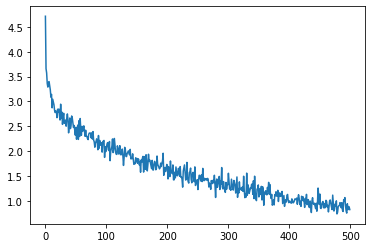

In [10]:
n_iters = 50000
print_every = 1000
plot_every =100

plot_losses = []
print_loss_total = 0  # Reset every print_every
plot_loss_total = 0  # Reset every plot_every

training_pairs = [tensorsFromPair(random.choice(pairs)) for i in range(n_iters)]

for iter in range(1, n_iters+1):
    # Load data
    training_pair = training_pairs[iter-1]
    input_tensor = training_pair[0]
    target_tensor = training_pair[1]
    
    # Clear gradients w.r.t. parameters
    #############
    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()
    #############
    
    # Forward pass
    loss = 0
    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)
    
    #############
    #hidden state initialization
    encoder_hidden = encoder.initHidden()
    decoder_hidden = decoder.initHidden()
    #############
    encoder_outputs = torch.zeros(MAX_LENGTH, encoder.hidden_dim, device=device)
    #############
    #encoder로 부터 output과 hidden을 추출하여 output을 배열에 넣어준다.
    for i in range(input_length):
        encoder_output, encoder_hidden = encoder(input_tensor[i], encoder_hidden)
        encoder_outputs[i] = encoder_output.reshape(-1)
    #############
    decoder_input = torch.tensor([[SOS_token]], device=device)
    #############
    decoder_hidden = encoder_hidden
    #0.5의 확률로 랜덤하게 teacher_forcing이 되도록 했다.
    use_teacher_forcing=random.random()>teacher_forcing_ratio
    if use_teacher_forcing:#teacher forcing이 될 때    
        for i in range(target_length):
            decoder_output, decoder_hidden = decoder(decoder_input, decoder_hidden, encoder_outputs)
            loss += criterion(decoder_output, target_tensor[i])
            decoder_input = target_tensor[i] #real target output이 다음 input이 되도록
    else:#teacher forcing이 되지 않을 때
        for i in range(target_length):
            decoder_output, decoder_hidden = decoder(decoder_input, decoder_hidden, encoder_outputs)
            loss += criterion(decoder_output, target_tensor[i])
            topv, topi = decoder_output.data.topk(1)
            #decoder가 추측한 단어가 다음 input이 되도록
            decoder_input = topi.squeeze().detach()
            if topi.item() == EOS_token:
                break
    #############

    # Backward pass
    #############
    loss.backward()
    #############

    # Updating parameters
    #############
    encoder_optimizer.step()
    decoder_optimizer.step()
    #############
    
    print_loss_total += loss.item() / target_length
    plot_loss_total += loss.item() / target_length

    if iter % print_every == 0:
        print('*'*25, 'iter%d'%iter, '*'*25)
        print('loss %.4f'%loss)
        print_loss_avg = print_loss_total / print_every
        print_loss_total = 0
        evaluateRandomly()

    if iter % plot_every == 0:
        plot_loss_avg = plot_loss_total / plot_every
        plot_losses.append(plot_loss_avg)
        plot_loss_total = 0

#################################################
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure()
plt.plot(plot_losses)

### *References*
[1] [practical pytorch](https://github.com/spro/practical-pytorch)(https://github.com/spro/practical-pytorch)

### *Discussion*
이번에는 GRU를 구현하였다. GRU는 LSTM과 성능은 비슷하지만 LSTM의 복잡한 구조를 간단하게 만들었다. gate가 2개이고 cell state가 없으며 output을 출력할 때 추가적인 non-linearity가 필요없다. decoder에서는 Attention을 사용하였다. Attention을 사용하지 않으면 단일 벡터가 문장 전체를 encoding해야 하는데 Attention을 사용하면 decoder가 모든 step에 대한 encoder output의 특정 부분에 집중할 수 있어 더 좋은 성능이 나온다. train을 할때는 teacher forcing 기법을 사용했는데 항상 decoder가 예측한 다음 단어를 다음 input으로 사용하는 것이 아니라 특정확률로 real target output을 다음 input으로 사용하는 것이다.

experiment는 프랑스어를 영어로 번역하는 것이다. 결과를 살펴보면 "you re the teacher ."같은 간단한 문장은 잘 해석하지만 "i m a fan of german opera ."같은 문장은 잘 해석하지 못한다. 또한 문장의 형식은 유사하게 갖추나 명사같이 일부분만 틀리는 경우도 있다. 저번과 마찬가지로 그래프에서의 loss와 print된 loss의 scale이 다른 것을 볼 수 있는데 print로 출력할 때 그냥 loss를 출력하기 때문이다. print_loss_avg를 출력하는 것이 합리적이라고 생각한다. teacher forcing 기법을 사용하지 않았을 때의 결과를 살펴보기 위해 추가적인 실험을 진행하였고 결과는 아래에 첨부하였다. teacher forcing 기법을 사용할때보다 loss가 줄어드는 속도가 느리다.

데이터가 저번과 같은 sequence이고, 모델 구조가 LSTM보다 단순하다 보니 저번 주의 실험보다는 구현하는 것이 쉬웠다. 번역은 정확도가 중요한데 결과물을 보니 의미가 완전 다른 문장들이 많이 보였다. 추후에 gpt나 transformer같은 최신 모델로 실험해보고 싶다. 

In [9]:
teacher_forcing_ratio=1 #teacher forcing 기법을 사용하지 않기 위해 teacher_forcing_ratio를 1로 변경

************************* iter1000 *************************
loss 21.1812
> je ne suis pas bon dans la simulation .
= i m not good at pretending .
< i m not the . .

************************* iter2000 *************************
loss 11.7281
> elles sont toutes mortes .
= they re all dead .
< they re very . .

************************* iter3000 *************************
loss 12.1315
> tu caches quelque chose .
= you re hiding something .
< you re very good .

************************* iter4000 *************************
loss 14.5318
> tu es cerne .
= you re surrounded .
< you re the .

************************* iter5000 *************************
loss 18.5824
> je fais encore mon marche .
= i m still shopping around .
< i m looking to my . .

************************* iter6000 *************************
loss 10.2300
> elle est plus une relation qu une amie .
= she is more an acquaintance than a friend .
< she s a a a . .

************************* iter7000 *************************
loss 19.

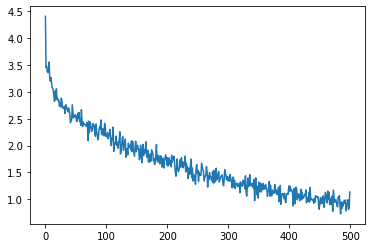

In [10]:
n_iters = 50000
print_every = 1000
plot_every =100

plot_losses = []
print_loss_total = 0  # Reset every print_every
plot_loss_total = 0  # Reset every plot_every

training_pairs = [tensorsFromPair(random.choice(pairs)) for i in range(n_iters)]

for iter in range(1, n_iters+1):
    # Load data
    training_pair = training_pairs[iter-1]
    input_tensor = training_pair[0]
    target_tensor = training_pair[1]
    
    # Clear gradients w.r.t. parameters
    #############
    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()
    #############
    
    # Forward pass
    loss = 0
    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)
    
    #############
    #hidden state initialization
    encoder_hidden = encoder.initHidden()
    decoder_hidden = decoder.initHidden()
    #############
    encoder_outputs = torch.zeros(MAX_LENGTH, encoder.hidden_dim, device=device)
    #############
    #encoder로 부터 output과 hidden을 추출하여 output을 배열에 넣어준다.
    for i in range(input_length):
        encoder_output, encoder_hidden = encoder(input_tensor[i], encoder_hidden)
        encoder_outputs[i] = encoder_output.reshape(-1)
    #############
    decoder_input = torch.tensor([[SOS_token]], device=device)
    #############
    decoder_hidden = encoder_hidden
    #0.5의 확률로 랜덤하게 teacher_forcing이 되도록 했다.
    use_teacher_forcing=random.random()>teacher_forcing_ratio
    if use_teacher_forcing:#teacher forcing이 될 때    
        for i in range(target_length):
            decoder_output, decoder_hidden = decoder(decoder_input, decoder_hidden, encoder_outputs)
            loss += criterion(decoder_output, target_tensor[i])
            decoder_input = target_tensor[i] #real target output이 다음 input이 되도록
    else:#teacher forcing이 되지 않을 때
        for i in range(target_length):
            decoder_output, decoder_hidden = decoder(decoder_input, decoder_hidden, encoder_outputs)
            loss += criterion(decoder_output, target_tensor[i])
            topv, topi = decoder_output.data.topk(1)
            #decoder가 추측한 단어가 다음 input이 되도록
            decoder_input = topi.squeeze().detach()
            if topi.item() == EOS_token:
                break
    #############

    # Backward pass
    #############
    loss.backward()
    #############

    # Updating parameters
    #############
    encoder_optimizer.step()
    decoder_optimizer.step()
    #############
    
    print_loss_total += loss.item() / target_length
    plot_loss_total += loss.item() / target_length

    if iter % print_every == 0:
        print('*'*25, 'iter%d'%iter, '*'*25)
        print('loss %.4f'%loss)
        print_loss_avg = print_loss_total / print_every
        print_loss_total = 0
        evaluateRandomly()

    if iter % plot_every == 0:
        plot_loss_avg = plot_loss_total / plot_every
        plot_losses.append(plot_loss_avg)
        plot_loss_total = 0

#################################################
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure()
plt.plot(plot_losses)